In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dataclasses
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms


class MNIST:
    def __init__(self, path = "/mnist"):
        transform = transforms.Compose([transforms.ToTensor()])
        set = datasets.MNIST(path, train=True, download=True, transform=transform)
        self.loader = DataLoader(set, batch_size=128, shuffle=True)

    def get_loader(self):
        return self.loader


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 784)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.tanh(x)
        x = x.view(-1, 1, 28, 28)
        return x

@dataclasses.dataclass
class GANTrainingOption:
    d_path: str
    g_path: str
    device: str
    epochs: int = 10
    lr: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999


class GAN:
    def __init__(self):
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.data = MNIST()

    def train(self, option: GANTrainingOption):
        device = torch.device(option.device)
        self.generator.to(device)
        self.discriminator.to(device)
        loader = self.data.get_loader()
        criterion = nn.BCEWithLogitsLoss()
        g_optimizer = optim.Adam(self.generator.parameters(), lr=option.lr, betas=(option.beta1, option.beta2))
        d_optimizer = optim.Adam(self.discriminator.parameters(), lr= option.lr, betas=(option.beta1, option.beta2))

        for epoch in range(option.epochs):
            for idex, (X_real, _) in enumerate(loader):
                X_real = X_real.to(device)
                g_optimizer.zero_grad()
                noise = torch.rand(X_real.shape[0], 128, device=device)
                X_fake = self.generator(noise)
                y_fake = self.discriminator(X_fake)
                g_loss = criterion(y_fake, torch.ones_like(y_fake))
                g_loss.backward()
                g_optimizer.step()

                d_optimizer.zero_grad()
                noise = torch.rand(X_real.shape[0], 128, device=device)
                X_fake = self.generator(noise)
                X_fake = X_fake.detach()
                y_real = self.discriminator(X_real)
                y_fake = self.discriminator(X_fake)
                # one-sided label smoothing
                label_real = torch.ones_like(y_real)
                label_fake = torch.zeros_like(y_fake)
                d_loss = criterion(y_real, label_real * 0.9) + criterion(y_fake, label_fake)
                d_loss.backward()
                d_optimizer.step()
        torch.save(self.generator.state_dict(), option.g_path)
        torch.save(self.discriminator.state_dict(), option.d_path)


In [2]:
gmodel = GAN()
option = GANTrainingOption(g_path = "generator.pth", d_path = "discriminator.pth", device = "cuda")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /mnist/MNIST/raw/train-images-idx3-ubyte.gz to /mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /mnist/MNIST/raw



In [3]:
gmodel.train(option)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [4]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


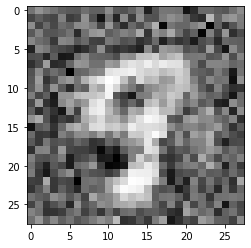

In [12]:
fake_input = torch.rand(1, 128, device="cuda")
fake = gmodel.generator(fake_input)
plt.imshow(fake[0][0].reshape(28,28).cpu().detach().numpy(), cmap='gray')
plt.show()